In [1]:
import string
import random
from random import randint
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
from scipy import ndimage 
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from skimage import transform

2023-04-11 10:54:09.257895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fizzer/.local/lib/python3.8/site-packages/cv2/../../lib64:/opt/ros/noetic/lib
2023-04-11 10:54:09.257922: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Setup: set file paths

In [2]:
# MODEL_SAVE_PATH = '/home/fizzer/ros_ws/src/controller_pkg/assets/models/char_recog_resize'
MODEL_SAVE_PATH = '/home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competition/assets/models/char_recog_resize_4'
MODEL_LOAD_PATH = '/home/fizzer/ros_ws/src/controller_pkg/assets/models/character_recognition'
MODEL_INPUT_SIZE = (20, 20)
LOAD_MODEL = False

# Part 1: Test generating single letter

In [3]:
chars = list(string.ascii_uppercase + string.digits)
ctoi = {c:i for i,c in enumerate(chars)}
itoc = {i:c for i,c in enumerate(chars)}
print(ctoi)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35}


# Part 2: Generate list of image of each character

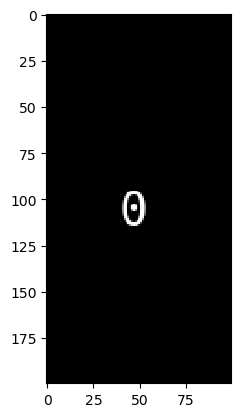

In [4]:
letter_images = []

FONT_HEIGHT = 30


for i in range(36):
    # zeros = np.zeros(shape=(int(FONT_HEIGHT * 2), int(FONT_HEIGHT * 1.5)), dtype=np.uint8)
    zeros = np.zeros(shape=(200,100), dtype=np.uint8)
    # plt.imshow(zeros)
    image = Image.fromarray(zeros)
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype(r"/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf", FONT_HEIGHT)
    text = itoc[i]
    # print(font.getsize(text))
    draw.text(xy=(int(MODEL_INPUT_SIZE[1]*2), int(MODEL_INPUT_SIZE[0]*4.5)), text=text, font=font, fill=255)
    letter_image = np.array(image)
    letter_images.append(letter_image)

letter_images = np.stack([ im for im in letter_images], axis=0)
letter_images.shape

# show random one
plt.imshow(letter_images[np.random.randint(36)], cmap='gray')

## 2.2: Rotate images

/tmp/ipykernel_21546/1601131659.py:2: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  rotated = ndimage.interpolation.rotate(image, np.random.randint(-20,20), axes=(0,1), reshape=True)


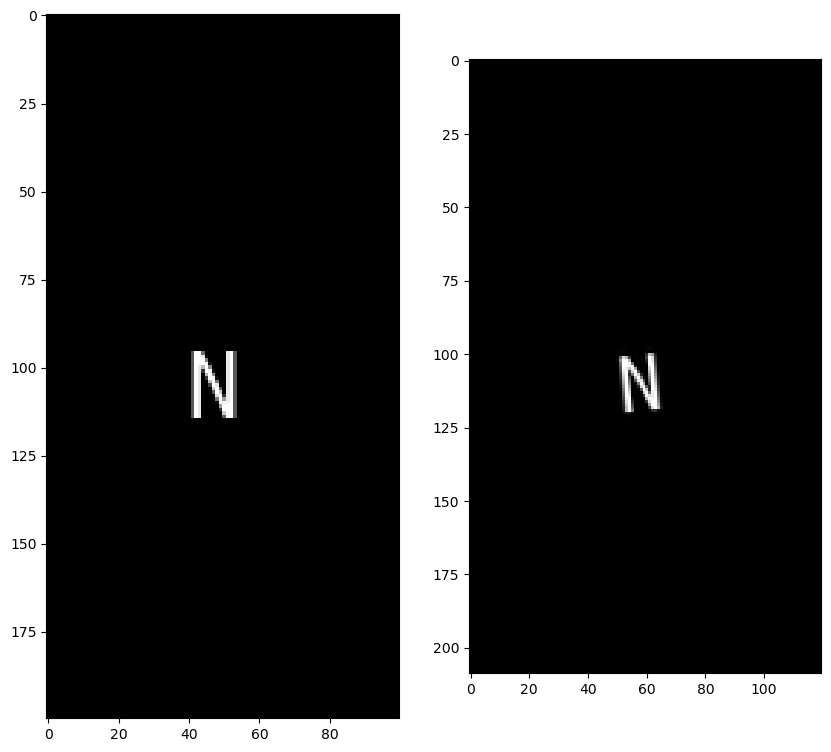

In [5]:
image = letter_images[np.random.randint(0,36)]
rotated = ndimage.interpolation.rotate(image, np.random.randint(-20,20), axes=(0,1), reshape=True)
# show random one 
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(rotated, cmap='gray')

## 2.4 Shear 

In [6]:
def unit_rand():
    return np.random.rand() * 2 - 1

/tmp/ipykernel_21546/4093186899.py:4: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  rotated = ndimage.interpolation.rotate(image, 90, axes=(0,1), reshape=True)
/tmp/ipykernel_21546/4093186899.py:7: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  unrotated = ndimage.interpolation.rotate(sheared, -90, axes=(0,1), reshape=True)


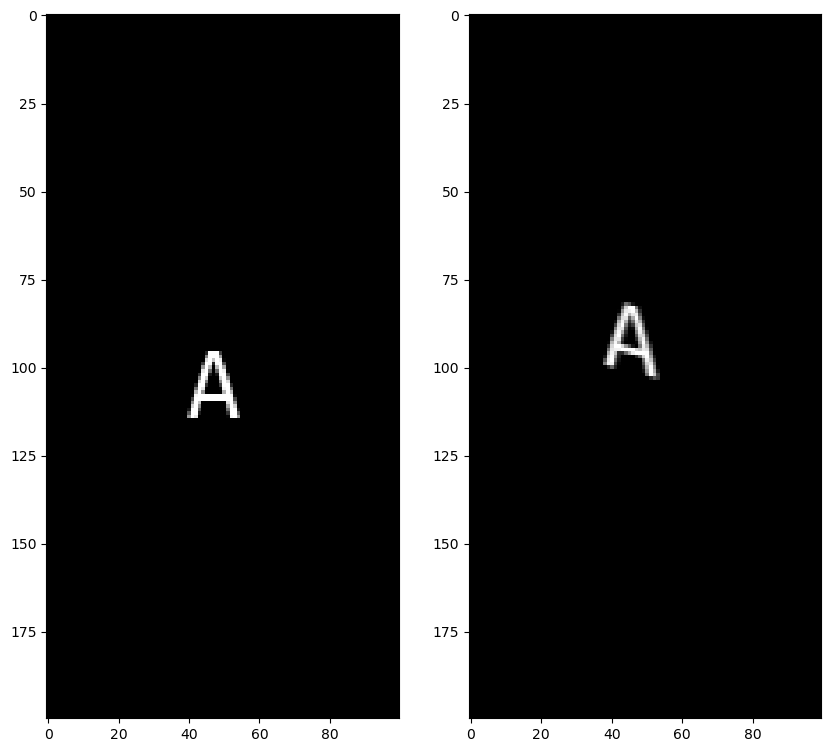

In [7]:
# Locate points of the documents
    # or object which you want to transform
image = letter_images[np.random.randint(0,36)]
rotated = ndimage.interpolation.rotate(image, 90, axes=(0,1), reshape=True)
shear_matrix = transform.AffineTransform(shear=np.random.rand()*1.8-0.9)
sheared = transform.warp(rotated, shear_matrix, mode='constant', cval=0)
unrotated = ndimage.interpolation.rotate(sheared, -90, axes=(0,1), reshape=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(unrotated, cmap='gray')

## 2.5 Random Blurring

#### Shrink down the size of the image to something like 10x8 pixels, then resize to original, creating random data losses

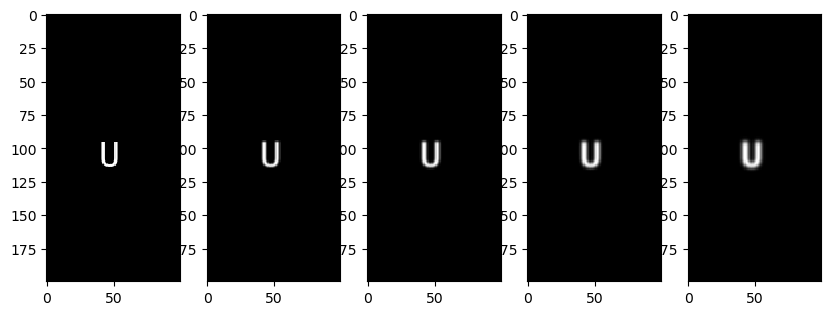

In [8]:
image = letter_images[np.random.randint(0,36)]
blur_3 = cv2.GaussianBlur(image, (3,3), 0)
blur_5 = cv2.GaussianBlur(image, (5,5), 0)
blur_7 = cv2.GaussianBlur(image, (7,7), 0)
blur_9 = cv2.GaussianBlur(image, (9,9), 0)

fig,axs = plt.subplots(1, 5, figsize=(10, 10))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(blur_3, cmap='gray')
axs[2].imshow(blur_5, cmap='gray')
axs[3].imshow(blur_7, cmap='gray')
axs[4].imshow(blur_9, cmap='gray')


# Part 3: Batch-ify it

In [34]:
RAND_RANGE = 0.6

X = np.empty(shape=(0, MODEL_INPUT_SIZE[0], MODEL_INPUT_SIZE[1])) 
Y = np.empty(shape=(0, 36))

for i in range(2000):
    crop_pixels = 2+np.random.randint(3)
    # random shear 
    rotated = np.rot90(letter_images, k=1, axes=(1,2))
    shear_matrix = transform.AffineTransform(shear=np.random.rand()*1.8-0.9)
    sheared = []
    for i in range(36):
        sheared.append(transform.warp(rotated[i], shear_matrix, mode='constant', preserve_range=True))
    unrotated = np.rot90(sheared, k=3, axes=(1,2))
    unrotated = np.array(unrotated, dtype=np.uint8)
    # random rotation
    # rotated = ndimage.interpolation.rotate(unrotated, np.random.randint(-20,20), axes=(1,2), reshape=False)
    # random blur 
    blur_factor = 1 + np.random.randint(1,4) * 2
    blurred = [cv2.GaussianBlur(unrotated[i], (blur_factor,blur_factor), 0) for i in range(36)]
    # capture only image
    for i in range(len(blurred)):
        blurred_img = blurred[i]
        _, mask = cv2.threshold(blurred_img, 1, 255, cv2.THRESH_BINARY)
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        maxContour = max(contours, key=cv2.contourArea)
        x,y,w,h = cv2.boundingRect(maxContour)
        blurred[i] = cv2.resize(blurred[i][y+crop_pixels:y+h-crop_pixels, x+crop_pixels:x+w-crop_pixels], (MODEL_INPUT_SIZE[0], MODEL_INPUT_SIZE[1]))
    # vectorize
    results = np.stack(blurred, axis=0)
    labels = tf.one_hot(np.arange(36), depth=36)
    X = np.append(X, results, axis=0)
    Y = np.append(Y, labels, axis=0)
X.shape, Y.shape

((72000, 20, 20), (72000, 36))

## 3.1 Sample randomly to validate labels

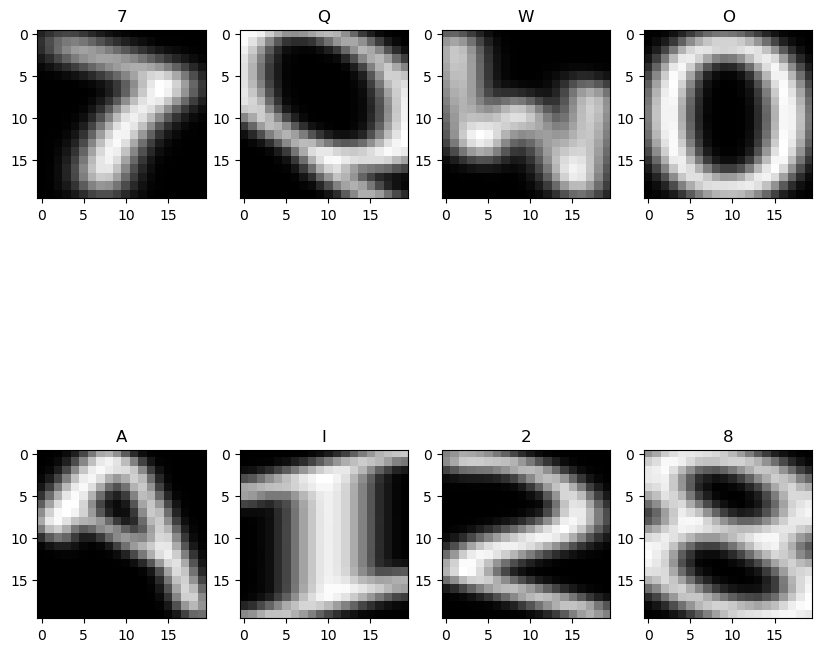

In [35]:
fig, axs = plt.subplots(2,4 , figsize=(10, 10))
for i in range(8):
    N = X.shape[0]
    n = np.random.randint(N)
    axs[i//4, i%4].imshow(X[n], cmap='gray')
    axs[i//4, i%4].set_title(itoc[np.argmax(Y[n])])


## 3.2: Data split

In [36]:
train_split = 0.9
N = X.shape[0]
n = int (N * train_split)
X_train = X[:n]
Y_train = Y[:n]
X_valid = X[n:]
Y_valid = Y[n:]

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(64800, 20, 20)
(64800, 36)
(7200, 20, 20)
(7200, 36)


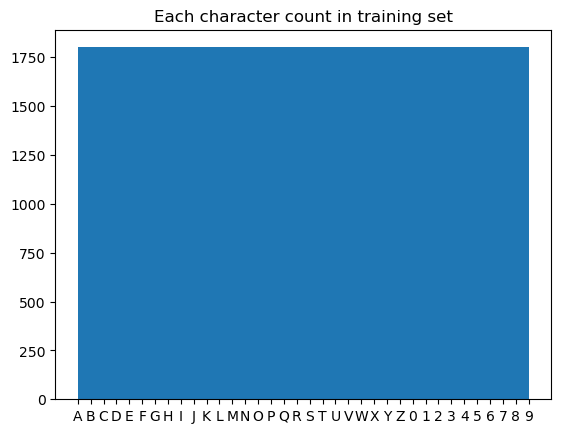

In [37]:
fig, axs = plt.subplots()
axs.hist(np.argmax(Y_train, axis=1), bins=36)
axs.set_title('Each character count in training set')
axs.set_xticks(range(36))
axs.set_xticklabels([c for c in list(ctoi.keys())])
print()

In [38]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(2,2), activation='relu', input_shape=(MODEL_INPUT_SIZE[0], MODEL_INPUT_SIZE[1], 1)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(36))
model.add(layers.Softmax())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 32)          320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 64)                102464    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4

In [39]:
EPOCHS = 10

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

if not LOAD_MODEL:
    history = model.fit(X_train, Y_train, epochs=EPOCHS, 
                        validation_data=(X_valid, Y_valid))
else:
    model = models.load_model(MODEL_LOAD_PATH)


Epoch 1/10
2025/2025 [==============================] - 9s 4ms/step - loss: 0.1492 - accuracy: 0.9571 - val_loss: 0.0237 - val_accuracy: 0.9936
Epoch 2/10
2025/2025 [==============================] - 9s 4ms/step - loss: 0.0267 - accuracy: 0.9931 - val_loss: 0.0455 - val_accuracy: 0.9851
Epoch 3/10
2025/2025 [==============================] - 9s 4ms/step - loss: 0.0214 - accuracy: 0.9949 - val_loss: 0.0097 - val_accuracy: 0.9965
Epoch 4/10
2025/2025 [==============================] - 9s 4ms/step - loss: 0.0082 - accuracy: 0.9981 - val_loss: 0.0026 - val_accuracy: 0.9990
Epoch 5/10
2025/2025 [==============================] - 9s 4ms/step - loss: 0.0219 - accuracy: 0.9951 - val_loss: 2.8768e-04 - val_accuracy: 0.9999
Epoch 6/10
2025/2025 [==============================] - 9s 4ms/step - loss: 0.0103 - accuracy: 0.9978 - val_loss: 0.0024 - val_accuracy: 0.9996
Epoch 7/10
2025/2025 [==============================] - 9s 4ms/step - loss: 0.0104 - accuracy: 0.9977 - val_loss: 0.0046 - val_accur

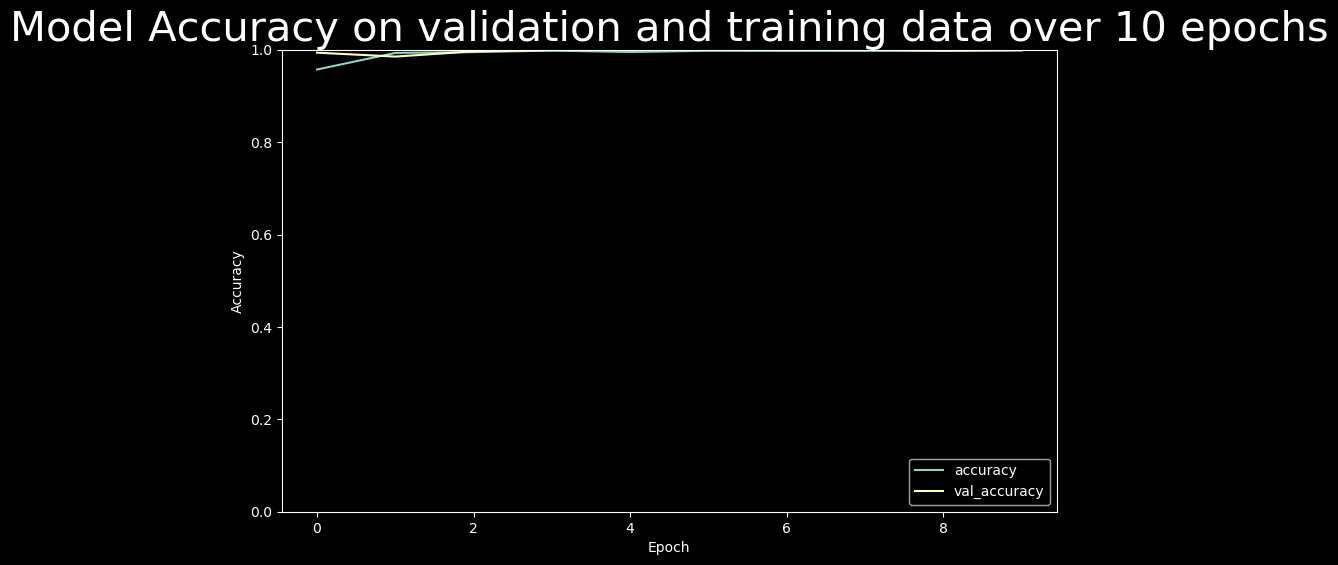

In [40]:

if not LOAD_MODEL:
    plt.style.use('dark_background')
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.0, 1.0])
    plt.legend(loc='lower right')
    plt.title(f"Model Accuracy on validation and training data over {EPOCHS} epochs", size=30)

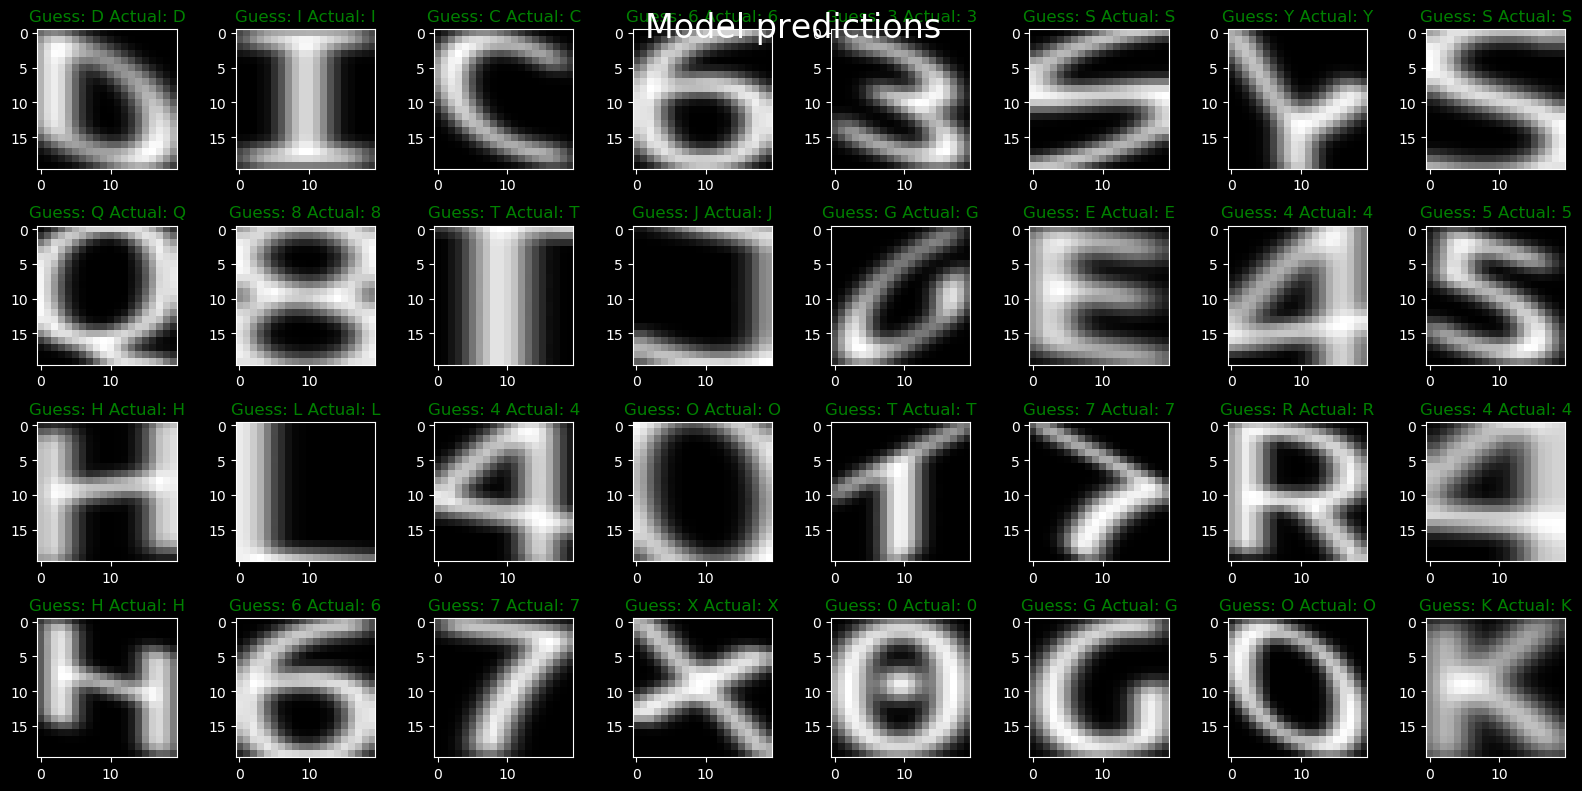

In [41]:

fig, axs = plt.subplots(4,8, figsize=(16,8))
for i in range(32):
    n = np.random.randint(X_valid.shape[0])
    input = tf.expand_dims(tf.expand_dims(X_valid[n], -1), 0)
    label = itoc[np.argmax(Y_valid[n])]
    ypred = str(itoc[np.argmax(model(input))])
    axs[i//8, i%8].imshow(X_valid[n], cmap='gray')
    if label == ypred:
        axs[i//8, i%8].set_title('Guess: ' + str(ypred) + ' Actual: ' + label, color='green')
    else:
        axs[i//8, i%8].set_title('Guess: ' + str(ypred) + ' Actual: ' + str(label), color='red')
fig.suptitle('Model predictions', fontsize=24)
fig.tight_layout()

In [42]:
model.save(MODEL_SAVE_PATH)

INFO:tensorflow:Assets written to: /home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competition/assets/models/char_recog_resize_4/assets


INFO:tensorflow:Assets written to: /home/fizzer/Insync/kmackenziesecondary@gmail.com/Google Drive - Shared with me/enph353_competition/assets/models/char_recog_resize_4/assets


In [43]:
%%timeit -r 8 -n 8
n = np.random.randint(X_valid.shape[0])
input = tf.expand_dims(tf.expand_dims(X_valid[n], -1), 0)
label = itoc[np.argmax(Y_valid[n])]
ypred = str(itoc[np.argmax(model(input))])
# print(ypred)

1.87 ms ± 315 µs per loop (mean ± std. dev. of 8 runs, 8 loops each)


: 